In [12]:
using LinearAlgebra
using Statistics
using Plots
using StatsPlots
using BenchmarkTools

In [90]:
# helper methods
function symmetric_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim,dim);
    for i = 1:dim
        for j = 1:i
            A[i,j] = rand(1:50);
            A[j,i] = A[i,j];
        end
    end
    if show_matrix
        display(A);
    end
    return A;
end

# we might change it to just rand(dim,dim)
function random_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim, dim);
    for i = 1:dim
        for j = 1:dim
            A[i,j] = rand(1:50);
        end
    end
    if show_matrix
        display(A);
    end
    return A
end

function diagonal_matrix(dim::Integer)::Matrix
    Diag = ones(dim,dim)
    return Diagonal(Diag)
end

function eye(dim::Integer)::Matrix
    return Matrix{Float64}(I,dim,dim);
end


function custom_cond(λₘₐₓ, λₘᵢₙ)
    return sqrt(λₘₐₓ/λₘᵢₙ)
end

function get_diag(A::Matrix)::Array #get diagonal as vector
    dim = size(A,1)
    diag = Array{Float64}(undef, dim)
    for i=1:dim
        diag[i] = A[i,i]
    end
    return diag
end

get_diag (generic function with 1 method)

# Metoda potęgowa

Poniżej przygotowana jest funkcja do metody iteracji prostej (metoda potęgowa), dzięki której można wyznaczyć największą co do modułu wartość własną, czyli promień spektralny macierzy, który opisany jest wzorem:
## $$\rho(A) = |\lambda_{max}| = \lim_{i \to \infty} \frac{||t_{i+1}||_{\infty}}{||t_{i}||_{\infty}}$$

Przy założeniu, że dowolny wektor początkowy t_{0} != 0, do uzyskania promienia spektralnego prowadzą iteracje postaci:
## $$t_{i+1} = At_{i},\ i=0,1,2...$$



In [26]:
function power_eigen(A::Matrix, iterations::Integer)::Tuple{Array, Array}
    n = size(A, 1);
    x = ones(n,1);
    results = Float64[];
    eig = nothing;
    x1 = x;
    
    for i = 1:iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
        eig = x' * A * x1 / (x' * x1);
        push!(results, eig[1]);
    end
    return eig, results;
end

function power_eigen_min(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    for i = 1:iterations
        x1 = x;
        x = A \ x;
        x = x / norm(x);
    end

    return x' * A * x1 / (x' * x1);
end

function power_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-6)::Tuple{Array, Array}
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    eig = nothing
    
    for i = 1:max_iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
        
        new_eig = x' * A * x1 / (x' * x1)

        if eig != nothing && abs(new_eig[1] - eig) < error
            return new_eig, x
        end
        eig = new_eig[1]
    end
    return eig, x
end

power_eigen_stop (generic function with 3 methods)

In [29]:
A = symmetric_matrix(5);
#A = random_matrix(5);
#A = [22 21 -8 4; 21 49 11 39; -8 11 60 -19; 4 39 -19 135]
λₘₐₓ, _ = power_eigen(A, 20);
λₘᵢₙ = power_eigen_min(A,20);
display(λₘₐₓ);
display(λₘᵢₙ);
e, v = eigen(A);
display(e);
display(v)
e, v = power_eigen_stop(A)
display(e)
display(v)

1×1 Array{Float64,2}:
 130.0943507911677

1×1 Array{Float64,2}:
 9.022466037315573

5-element Array{Float64,1}:
 -52.95107555333606
 -36.20127004879795
   9.022466037315468
  24.035528773650633
 130.09435079116747

5×5 Array{Float64,2}:
 -0.2943     0.745795   -0.411363  -0.0492487  -0.430734
  0.722277  -0.169554   -0.28015   -0.380056   -0.476067
 -0.537272  -0.633138   -0.259405   0.0649531  -0.488841
 -0.184734   0.0940687   0.764625  -0.471631   -0.387218
  0.262518   0.0729995   0.316788   0.791503   -0.446009

1×1 Array{Float64,2}:
 130.09435084405197

5×1 Array{Float64,2}:
 0.4307388685509919
 0.47605949626367894
 0.4888460437829673
 0.3872197417948367
 0.4460065023950493

In [32]:
# benchmark time for above Matrix
@btime  power_eigen(A, 20); # λₘₐₓ
@btime  power_eigen_min(A,20); # λₘᵢₙ

  23.100 μs (168 allocations: 17.67 KiB)
  17.899 μs (87 allocations: 13.84 KiB)


Jak widać z wyniku wykonania powyższego kodu, uzyskaliśmy największą co do modułu wartość własną macierzy. Ta wartość zgadza się z wartością otrzymaną za pomocą metody eigen(A). Za pomocą metody potęgowej można również wyznaczyć najmniejszą co do modułu wartość własną macierzy. Korzysta się z twierdzenia dotyczącego przesunięcia spektrum macierzy:<br />
### "Jeżeli $\lambda$ jest wartością własną macierzy A, to $\lambda + r$ jest wartością własną macierzy $A + \tau I$"
Należy pamiętać, że twierdzenie ma zastosowanie dla macierzy symetrycznych i dodatnio określonych. Po zastosowaniu przesunięcia $B = A - \lambda_{max}I$ można ponownie zastosować metodę iteracji prostej dla macierzy B zbieżną do największej co do modułu wartości własnej $\lambda = \lambda_{min}-\lambda_{max}$. Stąd można wyznaczyć $\lambda_{min}$.

In [33]:
B = A' * A;
λₘₐₓ, _ = power_eigen(B, 50);
n = size(A,1);
B_min = B - λₘₐₓ .* eye(n);
lambda_dash, _ = power_eigen(B_min, 50);
λₘᵢₙ = lambda_dash + λₘₐₓ;

Mając największą i najmniejszą wartość własną macierzy, można wyznaczyć współczynnik uwarunkowania macierzy:
$$cond(A)=\sqrt{\frac{\lambda_{max}(A^TA)}{\lambda_{min}(A^TA)}}$$
We wzorze przyjęto, że macierz A jest symetryczna, co oznacza, że $A=A^T$, ewentualnie można macierz wejściową doprowadzić do postaci symetrycznej stosując wzór $B = A^TA$

In [34]:
value = custom_cond(λₘₐₓ, λₘᵢₙ)
print(value)

cond(A)

[14.123049740376837]

14.41893494008367

# Metoda Jacobiego

In [93]:
function jacobi_eigen(A::Matrix, iterations::Integer)::Tuple{Matrix, Array}
    n = size(A,1);
    results = Float64[];
    for i = 1:iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = diagonal_matrix(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R; 
        DA = Diagonal(A);
        val = maximum(abs, DA);
        push!(results, val);
        
    end
    return A, results
end

function jacobi_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-2)::Tuple{Array, Matrix}
    n = size(A,1);
    eigs = nothing
    eigenVectors = eye(n)
    for i = 1:max_iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = diagonal_matrix(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R;
        
        new_eigs = get_diag(A)
        eigenVectors = eigenVectors*R
        if eigs != nothing && !any(broadcast(abs, new_eigs .- eigs) .> error)
            return get_diag(A), eigenVectors
        end
        eigs = new_eigs
        
    end
    return get_diag(A), eigenVectors
end

function maxst(A::Matrix)::Tuple{Integer,Integer}
    s = 1;
    t = 2;
    n = size(A,1);
    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
                s = r;
                t = c;
            end
        end
    end
    return s, t
end

maxst (generic function with 1 method)

In [73]:
#F = [12 6 -6 1; 6 16 2 100; -6 2 16 1 ;1 100 1 4];
#F = rand(4,4);
F = symmetric_matrix(10,true)
FJ, _ = jacobi_eigen(F, 15);

n = size(FJ,1);
FJ = Diagonal(FJ)

display(FJ)
e,v = eigen(F);
display(e)
display(v)
e,v = jacobi_eigen_stop(F)
display(e)
display(v)


10×10 Array{Float64,2}:
 16.0  15.0  31.0  26.0   8.0  28.0   4.0  37.0   2.0  50.0
 15.0  29.0  25.0  26.0  30.0  15.0  33.0  23.0  13.0  31.0
 31.0  25.0  17.0  48.0  40.0  22.0   3.0  45.0  20.0  15.0
 26.0  26.0  48.0  15.0  39.0  41.0   3.0  25.0  14.0  29.0
  8.0  30.0  40.0  39.0  17.0  11.0  45.0   3.0  17.0  18.0
 28.0  15.0  22.0  41.0  11.0  15.0  45.0  48.0  21.0   2.0
  4.0  33.0   3.0   3.0  45.0  45.0  37.0  34.0  23.0  26.0
 37.0  23.0  45.0  25.0   3.0  48.0  34.0  10.0  23.0  35.0
  2.0  13.0  20.0  14.0  17.0  21.0  23.0  23.0  16.0  22.0
 50.0  31.0  15.0  29.0  18.0   2.0  26.0  35.0  22.0  16.0

10×10 Diagonal{Float64,Array{Float64,1}}:
 240.25    ⋅        ⋅        ⋅       …     ⋅         ⋅       ⋅          ⋅ 
    ⋅    10.3754    ⋅        ⋅             ⋅         ⋅       ⋅          ⋅ 
    ⋅      ⋅      36.5805    ⋅             ⋅         ⋅       ⋅          ⋅ 
    ⋅      ⋅        ⋅      -5.25325        ⋅         ⋅       ⋅          ⋅ 
    ⋅      ⋅        ⋅        ⋅             ⋅         ⋅       ⋅          ⋅ 
    ⋅      ⋅        ⋅        ⋅       …     ⋅         ⋅       ⋅          ⋅ 
    ⋅      ⋅        ⋅        ⋅          -52.6379     ⋅       ⋅          ⋅ 
    ⋅      ⋅        ⋅        ⋅             ⋅      -58.8999   ⋅          ⋅ 
    ⋅      ⋅        ⋅        ⋅             ⋅         ⋅      4.63235     ⋅ 
    ⋅      ⋅        ⋅        ⋅             ⋅         ⋅       ⋅       -34.0

10-element Array{Float64,1}:
 -68.13866753966832
 -61.437928719264555
 -36.55746337216564
 -17.840315952623634
  -4.232906485845163
   7.138075065892309
  28.929655948254506
  37.68462650320103
  57.32229328837553
 245.13263126384356

10×10 Array{Float64,2}:
  0.296029    -0.0353613    0.630148    …   0.249067    0.45135    -0.291277
  0.00252687   0.0348565    0.189588       -0.252136   -0.178574   -0.311872
 -0.244919    -0.474315    -0.00369796     -0.320871    0.294233   -0.346131
  0.423581    -0.139094    -0.352341       -0.320243    0.254582   -0.345465
 -0.114471     0.533689     0.165814       -0.556247   -0.271626   -0.296412
 -0.541806     0.0656098    0.195459    …   0.359289   -0.0850316  -0.326789
  0.269501    -0.429059    -0.093644        0.23811    -0.675548   -0.32289
  0.257737     0.525062    -0.383781        0.389956    0.130365   -0.364698
  0.115473    -0.00213318   0.264341        0.0752814  -0.174941   -0.222473
 -0.462498    -0.0655539   -0.388818        0.126296    0.16743    -0.311982

10

10-element Array{Float64,1}:
 245.12931200576207
  57.23495567049125
  37.63464157143658
  28.954380811934072
   7.174337076416884
  -4.261084632638515
 -17.86295763189032
 -36.46456869524359
 -61.431407861311456
 -68.1076083149572

10×10 Array{Float64,2}:
 0.289277   0.448859   0.237787  -0.245444   …  -0.0430839    0.304852
 0.311353  -0.175914  -0.271615  -0.397386       0.0413489    0.00582688
 0.346099   0.299764  -0.308283   0.29585       -0.473449    -0.249037
 0.346664   0.250802  -0.30538    0.257572      -0.137939     0.413137
 0.295939  -0.254818  -0.565991   0.0130828      0.529534    -0.111389
 0.326092  -0.122108   0.359242   0.472766   …   0.0654542   -0.540533
 0.323393  -0.673135   0.21361   -0.095315      -0.430299     0.269147
 0.366119   0.128899   0.398176   0.119503       0.528335     0.250085
 0.221063  -0.174242   0.102877   0.102335      -0.00285457   0.133178
 0.31306    0.186792   0.131263  -0.608649      -0.0652657   -0.465862

In [39]:
# benchmark time for above Matrix
@btime jacobi_eigen(F, 15);

  13.600 μs (95 allocations: 21.00 KiB)


# QR algorithm

In [59]:
function QR_eigen(A::Matrix, iterations::Integer)::Tuple{Matrix, Array}
    results = Float64[];
    for k = 1:iterations
        Q, R = mgs(A);
        A = R * Q;

        DA = Diagonal(A);
        val = maximum(abs, DA);
        push!(results, val);
    end
    return A, results;
end

function QR_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-2)::Tuple{Array, Matrix}
    eigs = nothing
    pQ = diagonal_matrix(size(A,1))
    for k = 1:max_iterations
        Q, R = mgs(A);
        A = R * Q;
        pQ = pQ * Q
        new_eigs = get_diag(A)
        if eigs != nothing && !any(x -> x > error, broadcast(abs, new_eigs .- eigs)) 
            return get_diag(A), pQ
        end
        eigs = new_eigs
    end
    return get_diag(A), pQ;
end

function mgs(A::Matrix)::Tuple{Matrix, Matrix}
    n = size(A,1);
    R = zeros(n,n);
    Q = zeros(n,n);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]' * v;
            v = v - R[i,j] * Q[:,i];
        end
        R[j,j] = norm(v);
        Q[:,j] = v / R[j,j];
    end

    return Q, R;
end

mgs (generic function with 1 method)

In [60]:
A = symmetric_matrix(5);
AQR, _ = QR_eigen(A, 30);
Diag = Diagonal(AQR);
display(Diag);

e, v = eigen(A);
display(e)
display(v)
e, v = QR_eigen_stop(A);
display(e)
display(v)

5×5 Diagonal{Float64,Array{Float64,1}}:
 128.845     ⋅        ⋅        ⋅       ⋅ 
    ⋅     -37.5044    ⋅        ⋅       ⋅ 
    ⋅        ⋅      26.6474    ⋅       ⋅ 
    ⋅        ⋅        ⋅      17.3914   ⋅ 
    ⋅        ⋅        ⋅        ⋅      6.62062

5-element Array{Float64,1}:
 -37.50442119659456
   6.620618566671908
  17.391359891228817
  26.647412541675763
 128.84503019701833

5×5 Array{Float64,2}:
 -0.515029  -0.417199      0.611112   0.217239  -0.374218
 -0.356081   0.000653066  -0.301178  -0.763941  -0.445973
 -0.24442    0.427556     -0.423721   0.572993  -0.499594
  0.340188  -0.768284     -0.450809   0.165492  -0.251785
  0.657634   0.229956      0.391237  -0.116156  -0.589983

5-element Array{Float64,1}:
 128.8450301970184
 -37.49534318649966
  26.63833422097674
  17.39136020183263
   6.620618566671963

5×5 Array{Float64,2}:
 0.374218   0.512403   0.223462   0.611075  -0.417199
 0.445973   0.365146  -0.759706  -0.301035   0.000653028
 0.499594   0.23759    0.575783  -0.423825   0.427556
 0.251785  -0.342129   0.161351  -0.450841  -0.768284
 0.589983  -0.656209  -0.123899   0.391254   0.229956

In [143]:
@btime QR_eigen(A, 30);

  88.401 μs (1626 allocations: 217.20 KiB)


# Badania

Poniższe wykresy prezentują zbieżność tylko dla największych wartości własnych, ponieważ metoda potęgowa wyznacza tylko pojedynczą wartość.

In [61]:
function plot_eigenvalues(PlotA::Matrix, max_iterations::Integer, show_all_in_one::Bool=false, err::Bool=false)
    x = 1:max_iterations;
    e, v = eigen(PlotA);
    eigen_lambda = maximum(abs, e);
    if !err
        results_eig = zeros(0);
        for i = x
            append!(results_eig, eigen_lambda);
        end
    end

    #power method
    _, results_power = power_eigen(PlotA, max_iterations);
    if err
        results_power = broadcast(abs, results_power .- eigen_lambda);
        #results_power = abs.(results_power - eigen_lambda);
    end

    # jacobi algorithm
    _, results_jacobi = jacobi_eigen(PlotA, max_iterations);
    if err
        results_jacobi = broadcast(abs, results_jacobi .- eigen_lambda);
    end

    # QR algorithm
    _, results_qr = QR_eigen(PlotA, max_iterations);
    if err
        results_qr = broadcast(abs, results_qr .- eigen_lambda);
    end


    if err
        results = hcat(results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max error", label=["power" "jacobi" "QR"], xlabel="iteracje", ylabel="błąd lambda");
        results = results_power;
        plot_power = plot(x, results, title= "Lambda max error", label="power", xlabel="iteracje", ylabel="błąd lambda");
        results = results_jacobi;
        plot_jacobi = plot(x, results, title= "Lambda max error", label="jacobi", xlabel="iteracje", ylabel="błąd lambda");
        results = results_qr;
        plot_qr = plot(x, results, title= "Lambda max error", label="QR", xlabel="iteracje", ylabel="błąd lambda");
    else
        results = hcat(results_eig, results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max", label=["eigen" "power" "jacobi" "QR"], xlabel="iteracje", ylabel="wartosc lambda", ylim=(eigen_lambda*0.25, eigen_lambda*1.2));
        results = hcat(results_eig, results_power);
        plot_power = plot(x, results, title= "Lambda max", label=["eigen" "power"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_jacobi);
        plot_jacobi = plot(x, results, title= "Lambda max", label=["eigen" "jacobi"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_qr);
        plot_qr = plot(x, results, title= "Lambda max", label=["eigen" "QR"], xlabel="iteracje", ylabel="wartosc lambda");
    end
    if !show_all_in_one
        #show plots separate 
        display(plot_all);
        display(plot_power);
        display(plot_jacobi);
        display(plot_qr);
    else
        # all plots together
        all_plots = plot(plot_all, plot_power, plot_jacobi, plot_qr, size = (800,800), layout = grid(4, 1, heights=[0.25 , 0.25, 0.25, 0.25]));
        display(all_plots);
    end

end

plot_eigenvalues (generic function with 3 methods)

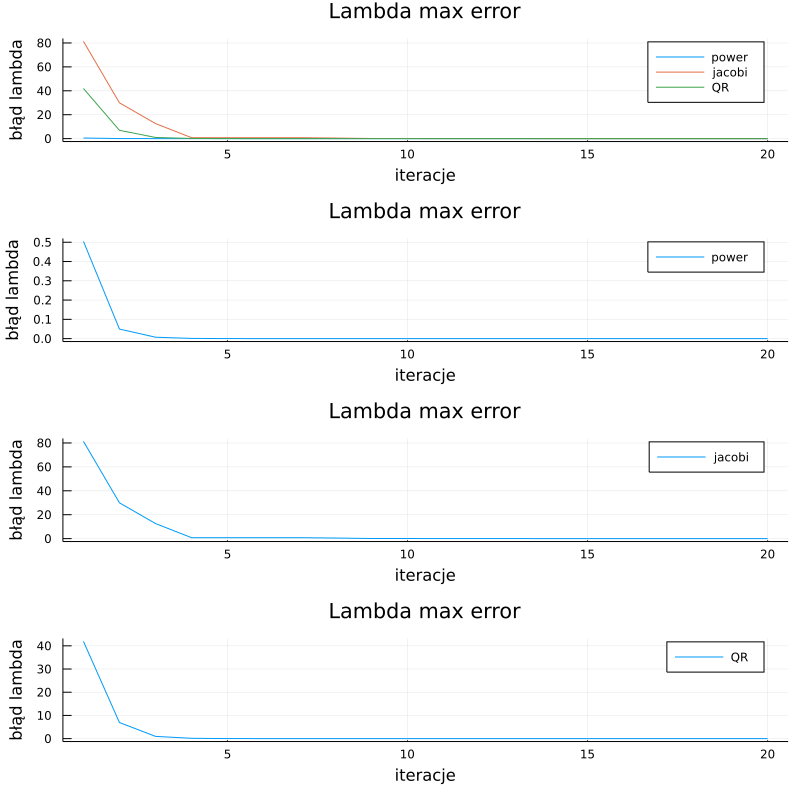

In [62]:
A = symmetric_matrix(5);
plot_eigenvalues(A, 20, true, true);

## Przypadki testowe

metoda potęgowa - macierze o elementach i wartościach własnych rzeczywistych<br />
metoda Jacobiego - macierze symetryczne (w tym hermitowskie)<br />
algorytm QR - macierze niesymetryczne

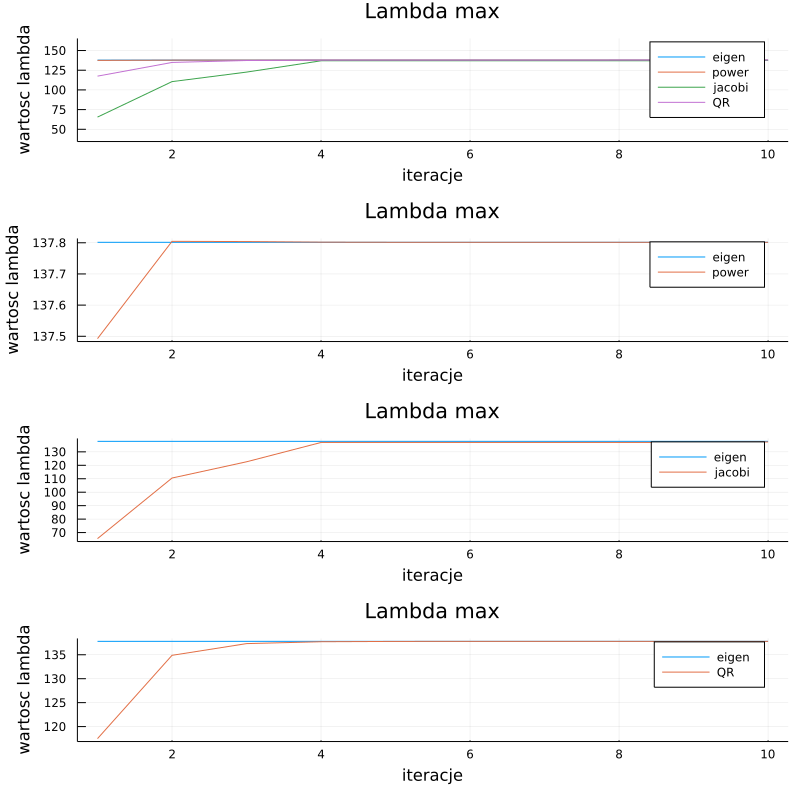

  0.164903 seconds (199.78 k allocations: 9.473 MiB)


In [63]:
Test1 = symmetric_matrix(5)
@time plot_eigenvalues(Test1, 10, true)

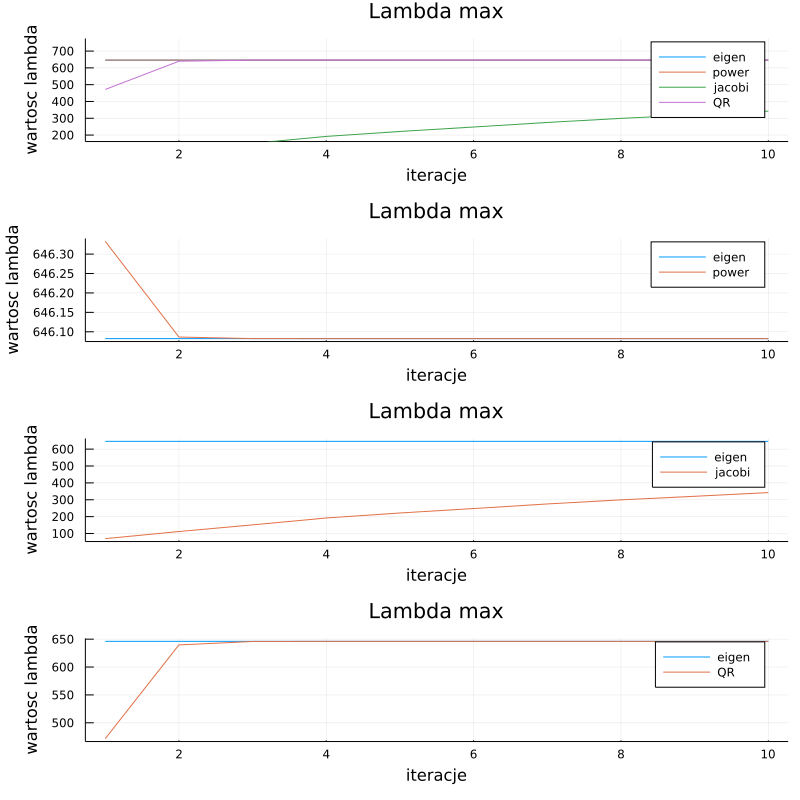

  0.094809 seconds (127.75 k allocations: 8.775 MiB)


In [64]:
Test2 = symmetric_matrix(25)
@time plot_eigenvalues(Test2, 10, true)

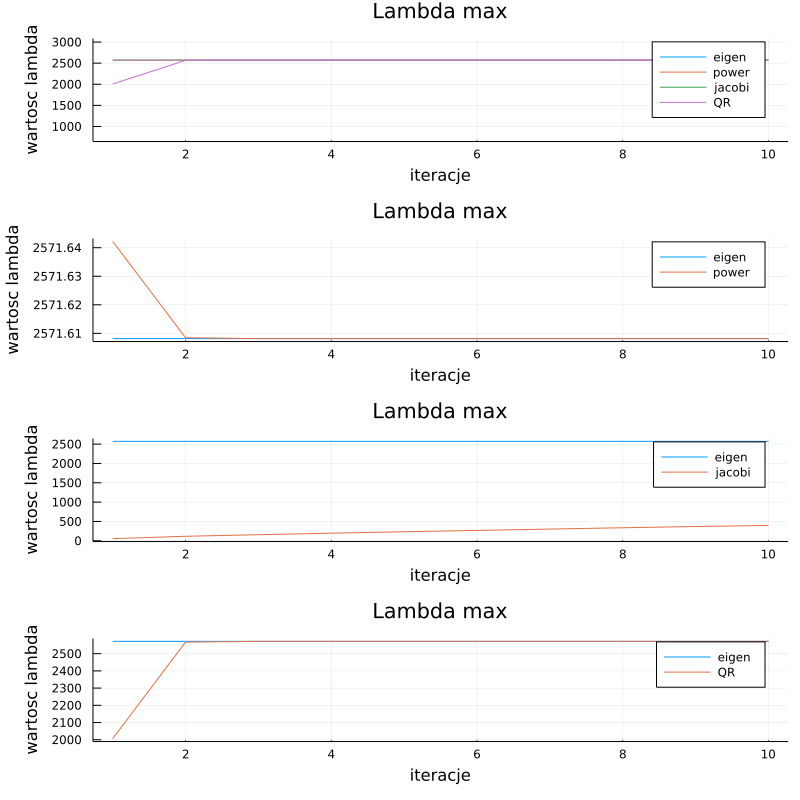

  0.196178 seconds (315.09 k allocations: 181.518 MiB, 18.89% gc time)


In [65]:
Test3 = symmetric_matrix(100)
@time plot_eigenvalues(Test3, 10, true)

Benchmarki dla wszystkich metod przy 3 rozmiarach macierzy:

In [79]:
A = symmetric_matrix(10)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A);

Power:   9.999 μs (66 allocations: 7.69 KiB)
QR:   1.032 ms (18633 allocations: 3.10 MiB)
Jacobi:   120.100 μs (802 allocations: 346.06 KiB)


In [94]:
A = symmetric_matrix(25)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A);

Power:   12.100 μs (50 allocations: 8.19 KiB)
QR:   103.733 ms (966636 allocations: 279.87 MiB)
Jacobi:   2.856 ms (3634 allocations: 7.87 MiB)


In [95]:
A = symmetric_matrix(100)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A);

Power:   75.900 μs (42 allocations: 16.38 KiB)
QR:   5.638 s (20011005 allocations: 16.99 GiB)
Jacobi:   422.256 ms (16999 allocations: 385.50 MiB)


In [69]:
A = symmetric_matrix(100)
@benchmark QR_eigen_stop(A)

BenchmarkTools.Trial: 
  memory estimate:  16.99 GiB
  allocs estimate:  20011005
  --------------
  minimum time:     5.279 s (15.39% GC)
  median time:      5.279 s (15.39% GC)
  mean time:        5.279 s (15.39% GC)
  maximum time:     5.279 s (15.39% GC)
  --------------
  samples:          1
  evals/sample:     1

In [70]:
# plot time benchmarks
#plot for [x1, x2, x3...] iterations
# plot_mean_time(A, [5, 10]);
function plot_mean_time(A::Matrix, iterations::Array, sample::Integer=2000)

    n = size(iterations,1);
    results = zeros(1);
    nam = [];

    for i = 1:n
        power = @benchmark  power_eigen(A, $iterations[$i]) samples = sample;
        power = mean(power.times)/1000;
        jacobi = @benchmark jacobi_eigen(A, $iterations[$i]) samples = sample;
        jacobi = mean(jacobi.times)/1000;
        qr = @benchmark QR_eigen(A, $iterations[$i]) samples = sample;
        qr = mean(qr.times)/1000;
        results = hcat(results, power, jacobi, qr);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
    end
    results = results[2:end];
    ctg = repeat(["Power", "Jacobi", "QR"], outer = n)
    
    plot_time = groupedbar(nam, results, group = ctg, xlabel = "Liczba iteracji", ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod dla okreśłonej liczby iteracji", bar_width = 0.67,
        lw = 0, framestyle = :box)
    display(plot_time);
    
end

# plot to reach stop condition
function plot_mean_time(A::Matrix, sample::Integer=5000)
    power = @benchmark  power_eigen_stop(A) samples = sample;
    power = mean(power.times)/1000;
    jacobi = @benchmark jacobi_eigen_stop(A) samples = sample;
    jacobi = mean(jacobi.times)/1000;
    qr = @benchmark QR_eigen_stop(A) samples = sample;
    qr = mean(qr.times)/1000;

    results = [power, jacobi, qr];
    nam = repeat(["time"], inner=3);
    ctg = repeat(["Power", "Jacobi", "QR"], outer = 1)

    display(results);

    plot_time = groupedbar(nam, results, group = ctg, ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod do warunku stopu", bar_width = 0.67,
        lw = 0, framestyle = :box);
    display(plot_time);
end

plot_mean_time (generic function with 4 methods)

3-element Array{Float64,1}:
  7.162063933333333
 27.3247692
 27.5110918

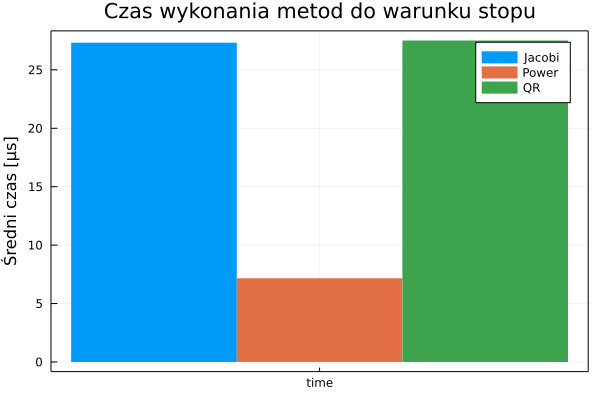

In [71]:
A = symmetric_matrix(5);
plot_mean_time(A);

# Zastosowanie

In [94]:
X = [sin.(pi * (1:6)/2) cos.(pi * (1:6)/4) rand(6,10)]' # generacja x w postaci macierzy X
X = X - repeat(mean.(eachcol(X)), 1, 12)' # usunięcie składowej stałej 
Rxx = X' * X/length(X[1,:]) # macierz korelacji
d, v = eigen(Rxx) #dekompozycja wg wartości własnych
v = reverse(v, dims=2) # ustawienie wektorów własnych wg wartości własnych malejących 
d = reverse(d) # ustawienie wartości własnych malejąco ZMIENILO SIE Z DIAGONALI NA ARRAY
K = 6 # liczba uwzględnionych składników głównych
Rxx_hat = zeros(6,6)

for i = 1:K
 Rxx_hat = Rxx_hat + d[i] * v[:,i] * v[:,i]' # odtworzenie macierzy korelacji
end

Error_Rxx = norm(Rxx - Rxx_hat) # błąd rekonstrukcji macierzy korelacji
display(Error_Rxx)
W = v[:,1:K]' # macierz przekształcenia PCA
Y = W * X'; # transformacja PCA x->y
#figure, plot(Y(1,:), Y(2,:),'*'); grid;title('Rozkład wektorów w przestrzeni 2D')
X_hat = W' * Y; # odtworzenie wektorów x
Error_X = norm(X' - X_hat) # błąd odtworzenia wektorów x
display(Error_X)

1.2426433443112613e-15

1.52719152434509e-15

In [62]:
# BRUDNOPIS
display(reverse([1 2; 3 4], dims=2))

2×2 Array{Int64,2}:
 2  1
 4  3